In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.distributions as dist

from torch.utils.data import DataLoader, TensorDataset

from torchvision.datasets import MNIST as raw_MNIST
from torchvision import transforms



import matplotlib.pyplot as plt

## Define a wrapper for the MNIST dataset which contains Morpho-MNIST properties

In [2]:
class MNIST_Dataset(TensorDataset):
    
    def __init__(self, *tensors, properties=None):
        super().__init__(*tensors)
        self.properties = properties
        self.data_dim = tensors[1].shape[1]
        
    def __getitem__(self, idx):
        x, y = super(MNIST_Dataset, self).__getitem__(idx)
        return x.float() / 255., y



class MNIST_Wrapper():
    
    def __init__(self):
        self.train_mnist = raw_MNIST('../data', train=True, download=True)
        self.test_mnist = raw_MNIST('../data', train=False)
        self.train_morpho = torch.FloatTensor(np.genfromtxt("../data/mnist-train-props.csv", delimiter=",", skip_header=1)[:,1:])
        self.test_morpho = torch.FloatTensor(np.genfromtxt("../data/mnist-test-props.csv", delimiter=",", skip_header=1)[:,1:])
        header = open("../data/mnist-train-props.csv").readline().strip().split(',')[1:]
        self.props = ['digit'] + header
        print("Potential properties:", self.props)
        self._morpho_col = {k: i for i, k in enumerate(header)}
        
    def get_dataset(self, train=True, properties=[]):
        mnist = self.train_mnist if train else self.test_mnist
        morpho = self.train_morpho if train else self.test_morpho
        target = None
        for prop in properties:
            if prop == 'digit':
                next_prop = nn.functional.one_hot(mnist.targets, 10).float()
            else:
                next_prop = morpho[:,self._morpho_col[prop]].unsqueeze(-1)
            if target is None:
                target = next_prop
            else:
                target = torch.cat((target, next_prop), dim=1)
        return MNIST_Dataset(mnist.data, target, properties=properties)

MNIST = MNIST_Wrapper()

Potential properties: ['digit', 'area', 'length', 'thickness', 'slant', 'width', 'height']


## Define a simple discriminator network for estimating MI

The idea is:

$I(x, y) = \mathbb{E}_{p(x, y)}\left[\log \dfrac{p(x, y)}{p(x)p(y)} \right]$.

If we draw random samples of paired $(x_i, y_i)$ and unpaired $(x'_j, y'_j)$, we then train a discriminator to predict the probability that the two go together:

$x_i, y_i \sim p(x, y), i = 1,\dots,N$  
$x'_i, y'_i \sim p(x)p(y), i = 1,\dots,N$  

Our training dataset provides a source of samples from both the joint and the marginal distributions. Let $s = 1$ denote paired samples from $p(x, y)$ and $s = 0$ denote unpaired samples from $p(x)p(y)$. The discriminator tries to estimate the probability

$p(s=1 | x, y) = \Pr((x, y) \sim p(x, y)) = 1 - \Pr((x, y) \sim p(x)p(y))$.

We can then estimate the log density ratio as

$\log \dfrac{p(x, y)}{p(x)p(y)} \approx \log \dfrac{p(s=1|x, y)}{p(s=0|x, y)}$

and then the mutual information can be approximated as

$I(x, y) \approx \mathbb{E}_{p(x, y)} [ \log p(s=1 | x,y) - \log p(s=0|x, y) ]
\approx \frac{1}{M} \sum_{j = 1}^M \log p(s=1 | x_j,y_j) - \log p(s=0|x_j, y_j)$

for independent samples $(x_j, y_j) \sim p(x, y)$.


If we train a classifier which directly outputs logits, then the MI estimate is simply the average of the logits.

## Testing on digits

Let's see how well this works at MI estimation, where $y$ is the digit identity.

In [3]:
class MI_Discriminator(nn.Module):
    
    def __init__(self, y_dim):
        super().__init__()
        self.h_img = nn.Sequential(nn.Linear(784, 400), nn.ReLU())
        self.h_prop = nn.Sequential(nn.Linear(y_dim, 50), nn.ReLU())
        self.out = nn.Sequential(nn.Linear(450, 100), nn.ReLU(), nn.Linear(100, 1))
        
    def forward(self, X, Y):
        h_img = self.h_img(X.reshape(-1, 784))
        h_prop = self.h_prop(Y)
        h = torch.cat((h_img, h_prop), dim=-1)
        return dist.Bernoulli(logits=self.out(h).squeeze(1))

In [4]:
N_SAMPLES = 500

props = ['digit']

train_data = MNIST.get_dataset(train=True, properties=props)
test_data = MNIST.get_dataset(train=False, properties=props)

In [5]:
print("y dim:", train_data.data_dim)
disc = MI_Discriminator(train_data.data_dim)
opt = torch.optim.Adam(disc.parameters())

y dim: 10


In [6]:
def rand_batch(train_data):
    ix = np.random.choice(len(train_data), (3, N_SAMPLES), replace=False)
    xy_paired = train_data[ix[0]]
    xy_unpaired = train_data[ix[1]][0], train_data[ix[2]][1]

    X = torch.cat((train_data[ix[0]][0], train_data[ix[1]][0]))
    Y = torch.cat((train_data[ix[0]][1], train_data[ix[2]][1]))
    s = torch.cat((torch.ones(N_SAMPLES), torch.zeros(N_SAMPLES)))
    return X, Y, s

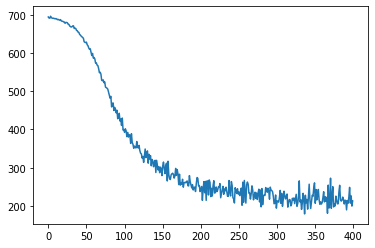

In [7]:
losses = []
for _ in range(400):
    X, Y, s = rand_batch(train_data)
    opt.zero_grad()
    loss = -disc(X, Y).log_prob(s).sum()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    
plt.plot(losses)



In [8]:
disc.eval()
with torch.no_grad():
    preds = disc(*test_data[np.random.choice(len(test_data), size=(1000,), replace=False)])

print("Estimated MI:", preds.logits.mean().item())

Estimated MI: 1.9832319021224976


### Side note: Alternative MI estimator

MINE: https://arxiv.org/pdf/1801.04062.pdf

The same basic network architecture works fine. Instead of directly estimating the MI, it optimizes a lower bound.

In [9]:
class MI_Estimator(nn.Module):
    
    def __init__(self, y_dim):
        super().__init__()
        self.h_img = nn.Sequential(nn.Linear(784, 400), nn.ReLU())
        self.h_prop = nn.Sequential(nn.Linear(y_dim, 50), nn.ReLU())
        self.out = nn.Sequential(nn.Linear(450, 100), nn.ReLU(), nn.Linear(100, 1))
        
    def forward(self, X, Y):
        h_img = self.h_img(X.reshape(-1, 784))
        h_prop = self.h_prop(Y)
        h = torch.cat((h_img, h_prop), dim=-1)
        return self.out(h)

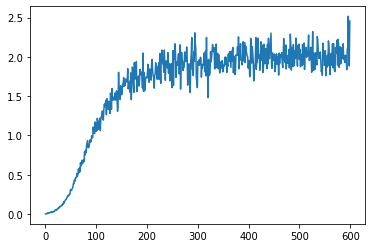

In [10]:
mi_est = MI_Estimator(train_data.data_dim)
opt = torch.optim.Adam(mi_est.parameters())

est = []
for _ in range(600):
    X, Y, s = rand_batch(train_data)
    opt.zero_grad()
    loss = -mi_est(X[s==1], Y[s==1]).squeeze(1).mean() + mi_est(X[s==0], Y[s==0]).squeeze(1).exp().mean().log()
    loss.backward()
    opt.step()
    est.append(-loss.item())
    
plt.plot(est);




In [11]:
print("MI estimate during optimization:", np.mean(est[-50:]))

MI estimate during optimization: 2.0183298540115358


In [12]:
mi_est.eval()
with torch.no_grad():
    T_paired = mi_est(*test_data[:])
    T_unpaired = mi_est(test_data[np.random.choice(len(test_data), size=(10000,), replace=False)][0],
                        test_data[np.random.choice(len(test_data), size=(10000,), replace=False)][1])

print("MI estimate on test set:", (T_paired.squeeze(1).mean() - T_unpaired.squeeze(1).exp().mean().log()).item())

MI estimate on test set: 2.036167860031128


# Those MI estimates were all pretty similar.

Let's try both on the different individual properties.

In [13]:
def run_MI_estimate_disc(props):
    train_data = MNIST.get_dataset(train=True, properties=props)
    test_data = MNIST.get_dataset(train=False, properties=props)

    #print("y dim:", train_data.data_dim)
    disc = MI_Discriminator(train_data.data_dim)
    opt = torch.optim.Adam(disc.parameters())
    
    losses = []
    for _ in range(1000):
        X, Y, s = rand_batch(train_data)
        opt.zero_grad()
        loss = -disc(X, Y).log_prob(s).sum()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    plt.plot(losses)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(', '.join(props))

    disc.eval()
    with torch.no_grad():
        preds = disc(*test_data[:])

    print("Properties:", props)
    print("Estimated MI:", preds.logits.mean().item())
    return preds.logits.mean().item()



Properties: ['digit']
Estimated MI: 2.279118537902832

Properties: ['area']
Estimated MI: 0.24466390907764435

Properties: ['length']
Estimated MI: 0.408706396818161

Properties: ['thickness']
Estimated MI: 1.725823998451233

Properties: ['slant']
Estimated MI: 2.3622238636016846

Properties: ['width']
Estimated MI: 1.8057447671890259

Properties: ['height']
Estimated MI: 0.11548818647861481


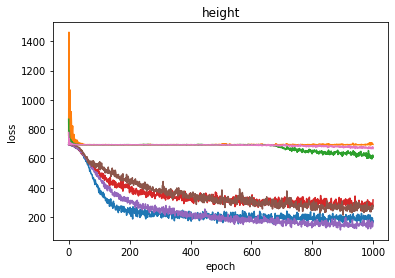

In [14]:
disc_est = dict()
for prop in MNIST.props:
    print()
    disc_est[prop] = run_MI_estimate_disc([prop]);

In [15]:
disc_est

{'digit': 2.279118537902832,
 'area': 0.24466390907764435,
 'length': 0.408706396818161,
 'thickness': 1.725823998451233,
 'slant': 2.3622238636016846,
 'width': 1.8057447671890259,
 'height': 0.11548818647861481}

### Compare with MINE estimator

In [16]:
def run_MI_estimate_mine(props):
    train_data = MNIST.get_dataset(train=True, properties=props)
    test_data = MNIST.get_dataset(train=False, properties=props)

    mi_est = MI_Estimator(train_data.data_dim)
    opt = torch.optim.Adam(mi_est.parameters())

    est = []
    for _ in range(1500):
        X, Y, s = rand_batch(train_data)
        opt.zero_grad()
        loss = -mi_est(X[s==1], Y[s==1]).squeeze(1).mean() + mi_est(X[s==0], Y[s==0]).squeeze(1).exp().mean().log()
        loss.backward()
        opt.step()
        est.append(-loss.item())

    plt.plot(est);
    plt.xlabel("epoch")
    plt.ylabel("MI")
    plt.title(', '.join(props))

    mi_est.eval()
    with torch.no_grad():
        T_paired = mi_est(*test_data[:])
        T_unpaired = mi_est(test_data[np.random.choice(len(test_data), size=(10000,), replace=False)][0],
                            test_data[np.random.choice(len(test_data), size=(10000,), replace=False)][1])

    print("Properties:", props)
    print("MI estimate during optimization:", np.mean(est[-100:]))
    test_MI = (T_paired.squeeze(1).mean() - T_unpaired.squeeze(1).exp().mean().log()).item()
    print("MI estimate on test set:", test_MI)
    return test_MI




Properties: ['digit']
MI estimate during optimization: 2.119062979221344
MI estimate on test set: 2.0954341888427734

Properties: ['area']
MI estimate during optimization: 2.6184353923797605
MI estimate on test set: 2.686164140701294

Properties: ['length']
MI estimate during optimization: 1.0542705672979356
MI estimate on test set: 0.881966769695282

Properties: ['thickness']
MI estimate during optimization: 1.6696225810050964
MI estimate on test set: 1.6845678091049194

Properties: ['slant']
MI estimate during optimization: 2.699377644062042
MI estimate on test set: 2.636889696121216

Properties: ['width']
MI estimate during optimization: 1.8379081737995149
MI estimate on test set: 1.8384288549423218

Properties: ['height']
MI estimate during optimization: -1.8901824951171875e-05
MI estimate on test set: -2.86102294921875e-06


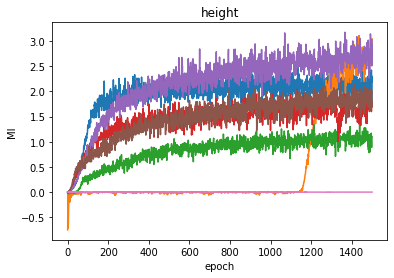

In [17]:
mine_est = dict()
for prop in MNIST.props:
    print()
    mine_est[prop] = run_MI_estimate_mine([prop]);

In [18]:
mine_est

{'digit': 2.0954341888427734,
 'area': 2.686164140701294,
 'length': 0.881966769695282,
 'thickness': 1.6845678091049194,
 'slant': 2.636889696121216,
 'width': 1.8384288549423218,
 'height': -2.86102294921875e-06}